# Figure 2 Analysis

This notebook analyzes and visualizes sequence data for ER and non-ER BEPs. It includes sequence processing, transmembrane domain prediction, and region-specific sequence extraction.

In [1]:
# === Configuration ===
import os

INPUT_DIR = "input/"
OUTPUT_DIR = "output/"

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)


In [2]:
# === Plotting Style ===
import matplotlib as mpl

def set_plot_style():
    mpl.rcParams.update({
        'font.sans-serif': 'Arial',
        'font.family': 'sans-serif',
        'pdf.fonttype': 42,
    })

    global axis_label_fontsize, axis_tick_labels_fontsize, legend_fontsize, title_fontsize
    axis_label_fontsize = 8
    axis_tick_labels_fontsize = 8
    legend_fontsize = 8
    title_fontsize = 10

    global er_color, non_er_color, mito_color, nuc_color, cyto_color, puncta_color, PM_color, no_exp_color
    er_color = (142/255, 200/255, 107/255)
    non_er_color = (46/255, 49/255, 146/255)
    mito_color = (179/255, 134/255, 188/255)
    nuc_color = (249/255, 240/255, 126/255)
    cyto_color = (191/255, 190/255, 190/255)
    puncta_color = (108/255, 203/255, 221/255)
    PM_color = (242/255, 124/255, 121/255)
    no_exp_color = (1, 1, 1)

set_plot_style()


In [3]:
import pandas as pd
import numpy as np
import os
import collections
import re

#for stats
from scipy import stats
from scipy.stats import fisher_exact, mannwhitneyu,ttest_ind, spearmanr, pearsonr, kruskal
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio import SeqIO
from Bio.Seq import Seq
import peptides


# for plotting
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [4]:
input_path = 'input/'
output_path = 'output/'

def fasta_to_dataframe(file_path):
    data = {'orf_name': [], 'aa_seq': []}
    for record in SeqIO.parse(file_path, "fasta"):
        data['orf_name'].append(record.id)
        data['aa_seq'].append(str(record.seq))
    df = pd.DataFrame(data)
    return df

# Reading f28_tms.fa into a DataFrame
f28_tms_df = fasta_to_dataframe(input_path+"f28_tms.fa")

# Reading f28_seqs.fa into a DataFrame
f28_seqs_df = fasta_to_dataframe(input_path+"f28.fasta")

# List of IDs for which loc should be 'ER' and 'nonER'
er_ids = ['YBR196C-A', 'YDL118W', 'YIL134C-A', 'YLL006W-A', 'YMR151W', 'YOL035C', 'YPR126C']
noner_ids = ['YAL066W', 'YBL100W-C', 'YBR296C-A', 'YCL058C', 'YDL187C',
       'YEL035C', 'YER014C-A', 'YFL032W', 'YGL149W', 'YGR035W-A',
       'YHR021W-A', 'YKL183C-A', 'YLR123C', 'YLR406C-A', 'YML090W',
       'YMR230W-A', 'YNL303W', 'YOR183W', 'YPR039W']

# Function to determine if ER value based on ID
def get_loc_value(id):
    if id in er_ids:
        return 'ER BEPs'
    elif id in noner_ids:
#         return 'non-ER'
        return 'other TMD-containing BEPs'
    else:
        return 'None'

# Add 'loc' column to f28_seqs_df
f28_seqs_df['loc'] = f28_seqs_df['orf_name'].apply(lambda x: get_loc_value(x))
f28_seqs_df = f28_seqs_df[f28_seqs_df['loc'].notna()]

# Function to extract the relevant part of the ID
def extract_id(id):
    return id.split('_')[0]

# Add 'loc' column to f28_tms_df
f28_tms_df['loc'] = f28_tms_df['orf_name'].apply(lambda x: get_loc_value(extract_id(x)))


f28_seqs_df.set_index('orf_name', inplace=True)
f28_tms_df.set_index('orf_name', inplace=True)

f28_seqs_df.sort_index(inplace=True)
f28_tms_df.sort_index(inplace=True)

# all of the tms er/non-er labels match that of the seqs
for tms_key, tms_row in f28_tms_df.iterrows():
    orf_name = tms_key.rsplit('_', 3)[0]
    seq_row = f28_seqs_df.loc[orf_name]
    assert seq_row['loc'] == tms_row['loc']

f28_seqs_df.shape, f28_tms_df.shape


## extract regions of the sequences
tms_by_orf_name = collections.defaultdict(list)

for tms_key, tms_row in f28_tms_df.iterrows():
    # start/end are 1-indexed and inclusive
    orf_name, num_tms, start, end = tms_key.rsplit('_', 3)
    del num_tms, start, end
    seq_row = f28_seqs_df.loc[orf_name]
    start = seq_row['aa_seq'].find(tms_row['aa_seq'])
    assert start != -1
    tms_by_orf_name[orf_name].append({
        'start': start,
        'end': start + len(tms_row['aa_seq']),
        'seq': tms_row['aa_seq'],
    })
                           
# sort tms by start index
for orf_name, tms in tms_by_orf_name.items():
    tms_by_orf_name[orf_name] = sorted(tms, key=lambda tms: tms['start'])
    
tms_by_orf_name = dict(tms_by_orf_name)

# check that we can slice like seq[start:end]
for orf_name, tmss in tms_by_orf_name.items():
    for tms in tmss:
        assert tms['seq'] == f28_seqs_df.loc[orf_name]['aa_seq'][tms['start']:tms['end']]

## extract different parts of sequence        
columns = ['method', 'orf_name', 'loc', 'region', 'seq']
data = []
orf_name_col = 'orf_name'

df = pd.read_csv('input/f28_phobius_tmhmm.csv')

cols_by_method = {
    'phobius': ['TM', 'PREDICTION'],
    'tmhmm': ['PredHel', 'Topology'],   
}

def pred_to_tms(orf_name, pred):
    intervals = list(map(lambda s: [int(i) for i in s.split('-')], [s for s in re.split('[io]', pred) if s]))
    tmss = []
    for start, end in intervals:
        tmss.append({
            'start': start-1,
            'end': end,
            'seq': f28_seqs_df.loc[orf_name]['aa_seq'][start-1:end],
        })
    return tmss

    
for method, cols in cols_by_method.items():
    num_col, pred_col = cols
    preds = df[[orf_name_col, pred_col]].loc[df[num_col] > 0].set_index(orf_name_col)
    tms_by_orf_name = collections.defaultdict(list)
    for orf_name, row in preds.iterrows():      
        for tms in pred_to_tms(orf_name, row[pred_col]):
            tms_by_orf_name[orf_name].append(tms)
    tms_by_orf_name = dict(tms_by_orf_name)

    for orf_name, tmss in tms_by_orf_name.items():
        seq_row = f28_seqs_df.loc[orf_name]
                
        seq = seq_row['aa_seq']
        loc = seq_row['loc']

        # full
        data.append([method, orf_name, loc, 'full', seq])
        # n-term
        data.append([method, orf_name, loc, 'n-term', seq[:tmss[0]['start']]])
        # c-term
        data.append([method, orf_name, loc, 'c-term', seq[tmss[-1]['end']:]])
        # tmd
        for tms in tmss:
            data.append([method, orf_name, loc, 'tmd', seq[tms['start']:tms['end']]])
        # non-tmd
        data.append([method, orf_name, loc, 'non-tmd', seq[:tmss[0]['start']]])
        data.append([method, orf_name, loc, 'non-tmd', seq[tmss[-1]['end']:]])
        for tms_left, tms_right in zip(tmss[:-1], tmss[1:]):
            # internal
            data.append([method, orf_name, loc, 'non-tmd', seq[tms_left['end']:tms_right['start']]])

    

chop_chop_df = pd.DataFrame(columns=columns, data=data)
# save
# chop_chop_df.loc[chop_chop_df.region=='tmd'].to_excel('output/TMDs_both_methods.xlsx', index=False)

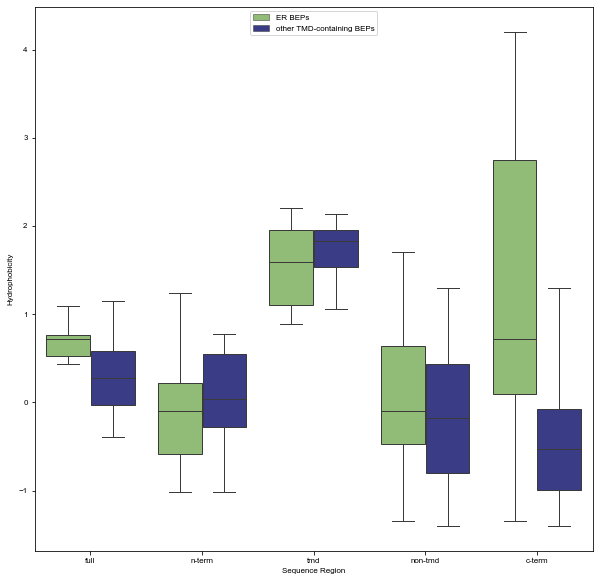

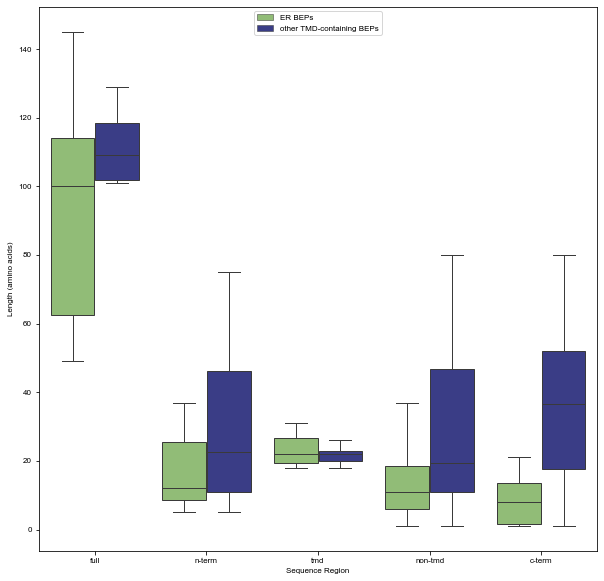

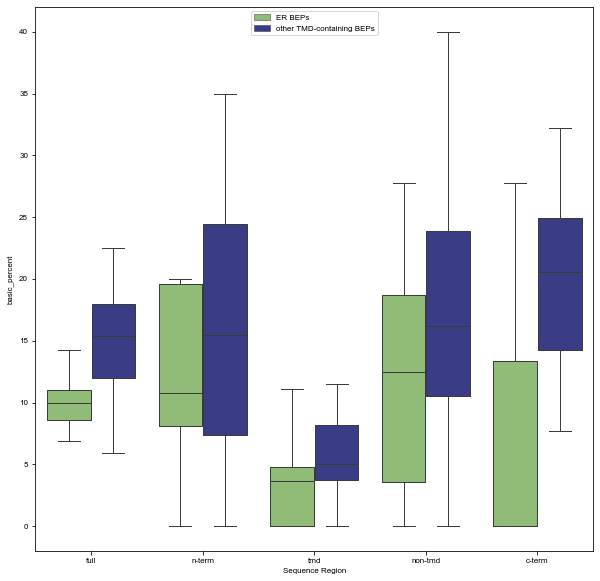

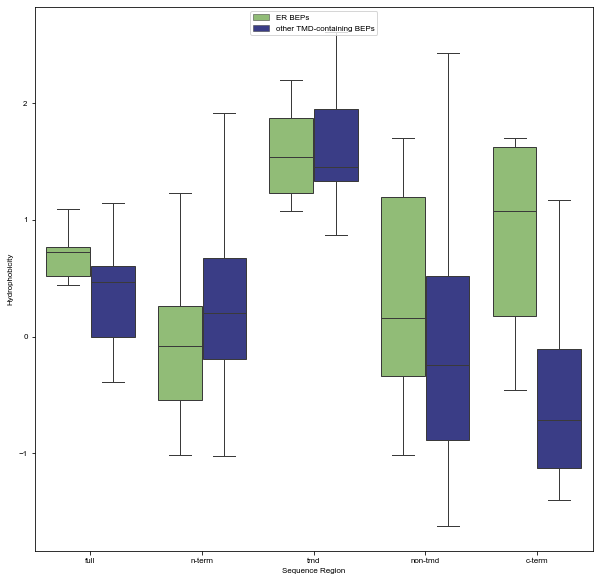

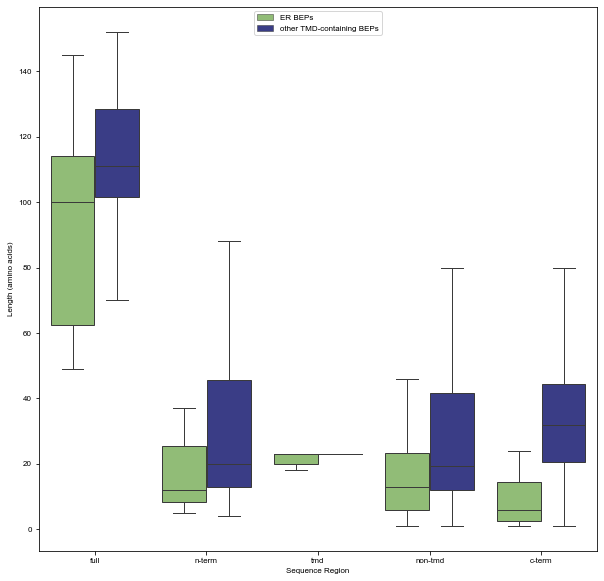

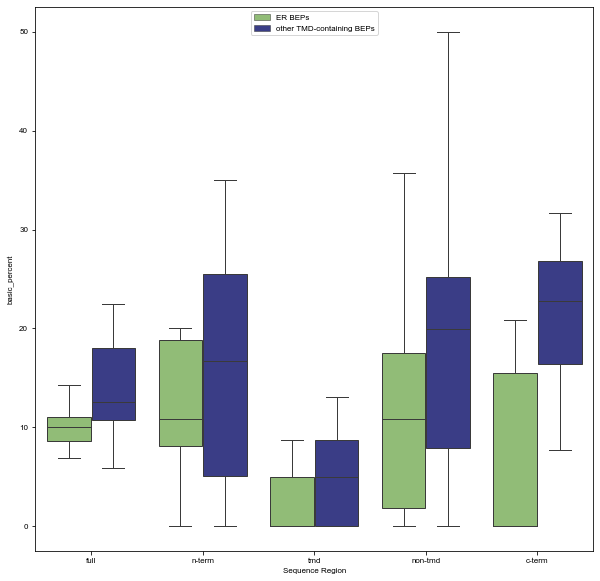

In [5]:

## measure biochemical properties and plot

filename = "output/statistics_figure2.txt"

# Create the file if it doesn't exist
if not os.path.exists(filename):
    open(filename, 'w').close()

def calculate_biochemical_properties(df):
    hydrophobicity_values = []
    charged_values = []
    aliphatic_values = []
    aromatic_values = []
    nonpolar_values = []
    isoelectric_point = []
    basic_values = []
    acidic_values = []
    length_values = []

    for seq in df['seq']:
        # Calculate hydrophobicity using the peptides module
        sequence=seq
        peptide = peptides.Peptide(sequence)
        hydrophobicity_values.append(peptide.hydrophobicity())
        charged_values.append((peptide.counts()['D'] + peptide.counts()['E']+
                              peptide.counts()['R']+ peptide.counts()['K'] +
                              peptide.counts()['H'])/len(sequence)*100)
        aliphatic_values.append((peptide.counts()['A']+ peptide.counts()['I']+
                              peptide.counts()['L']+ peptide.counts()['V'])/len(sequence)*100)
        aromatic_values.append((peptide.counts()['F']+ peptide.counts()['H']+
                              peptide.counts()['W']+ peptide.counts()['Y'])/len(sequence)*100)
        nonpolar_values.append((peptide.counts()['A']+ peptide.counts()['C']+
                                peptide.counts()['I']+ peptide.counts()['L']+
                                peptide.counts()['M']+ peptide.counts()['P']+
                                peptide.counts()['V']+ peptide.counts()['W']+
                                peptide.counts()['Y']+peptide.counts()['F'] +
                                peptide.counts()['G'])/len(sequence)*100)
        isoelectric_point.append(peptide.isoelectric_point())
        basic_values.append((peptide.counts()['H']+ peptide.counts()['K']+
                              peptide.counts()['R'])/len(sequence)*100)
        acidic_values.append((peptide.counts()['D']+ peptide.counts()['E'])/len(sequence)*100)
        length_values.append(len(sequence))

    # Add a new column for hydrophobicity in the DataFrame
    df['Hydrophobicity'] = hydrophobicity_values
    df['charged_percent'] = charged_values
    df['aliphatic_percent'] = aliphatic_values
    df['aromatic_percent'] = aromatic_values
    df['nonpolar_percent'] = nonpolar_values
    df['isoelectric_point'] = isoelectric_point
    df['basic_percent'] = basic_values
    df['acidic_percent'] = acidic_values
    df['Length (amino acids)'] = length_values
    
    return df


# Calculate hydrophobicity for f28_seqs_df
chop_chop_df = calculate_biochemical_properties(chop_chop_df)

from scipy.stats import norm
from scipy.stats import mannwhitneyu

methods = ['phobius','tmhmm']
variables = ['Hydrophobicity', 'Length (amino acids)', 'basic_percent']
category_order = ['full', 'n-term', 'tmd', 'non-tmd', 'c-term']

for method in methods:

    df = chop_chop_df.loc[(chop_chop_df.method==method)&(chop_chop_df.region.isin(category_order))].copy()

    for variable in variables:
        plt.figure(figsize=(10, 10))
        sns.boxplot(data=df, x='region', y=variable, hue='loc', hue_order = ['ER BEPs',
                                                                             'other TMD-containing BEPs'], 
                    palette=[er_color, non_er_color], order=category_order, showfliers=False, linewidth=1)

        plt.xlabel('Sequence Region', fontsize=axis_label_fontsize)
        plt.ylabel(variable, fontsize=axis_label_fontsize, labelpad=5)
        plt.xticks(fontsize=axis_tick_labels_fontsize)
        plt.yticks(fontsize=axis_tick_labels_fontsize)
        plt.legend(fontsize=axis_tick_labels_fontsize, loc='upper center')
        plt.show()

        for i, region in enumerate(category_order):
            # Perform Mann-Whitney U test
            ER_variable = df[(df['loc'] == 'ER BEPs') & (df['region'] == region)][variable]
            non_ER_variable = df[(df['loc'] == 'other TMD-containing BEPs') 
                                 & (df['region'] == region)][variable]
            statistic, p_value = mannwhitneyu(ER_variable, non_ER_variable)

            # compute effect size r:
            z = norm.ppf(p_value / 2) * (-1 if statistic > len(ER_variable) * len(non_ER_variable) / 2 else 1)
            r = z / np.sqrt(len(ER_variable) + len(non_ER_variable))
            with open("output/statistics_figure2.txt", "a") as f:
                f.write(
                        f"meth: {method}, var: {variable}, region: {region}, "
                        f"n= {ER_variable.shape[0] + non_ER_variable.shape[0]}, "
                        f"pval: {p_value}, z-score: {z}, effect size: {r}\n"
                        )

#         plt.savefig('output/' + method + '_' + variable + '_region_compare.pdf', dpi=300)

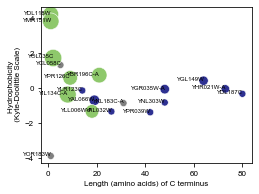

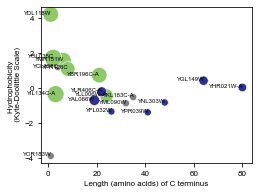

In [6]:
fit_loc_28 = pd.read_csv('input/fitness_28BEPs_Vakirlis_et_al_2020.csv')

df_per_ER  = chop_chop_df.merge(fit_loc_28.drop_duplicates(subset='orf_name')[['orf_name','Percent_ER_expressing_cells']], 
                   how='left', on='orf_name')
df_per_ER['Percent_ER_expressing_cells'] = df_per_ER['Percent_ER_expressing_cells']*100


# Update the 'loc_bin2' column if 'orf_name' is in breakdown_orfs
breakdown_orfs = ["YCL058C", "YER014C-A","YKL183C-A","YML090W","YOR183W"] #based on Suuplemental Figure 2
df_per_ER.loc[df_per_ER['orf_name'].isin(breakdown_orfs), 'loc'] = "processed/undefined"
df_per_ER.rename(columns={'loc':'Location', 
                          'Percent_ER_expressing_cells':'Percent expressing cells ER'}, inplace=True)

# Plotting
for method in df_per_ER['method'].unique():
    df = df_per_ER.loc[(df_per_ER['method'] == method) & (df_per_ER['region'] == 'c-term')].copy()
    
    plt.figure(figsize=(3.7,2.8))
    scatter = sns.scatterplot(data=df, x='Length (amino acids)', y='Hydrophobicity', 
                              hue='Location', palette=[non_er_color,er_color, 'grey'], 
                              size='Percent expressing cells ER', sizes=(50, 300), legend=False)
    
    # Annotate points with ORF name
    for i, row in df.iterrows():
        plt.text(row['Length (amino acids)'], row['Hydrophobicity'], row['orf_name'], fontsize=6, ha='right')
    
    plt.xlabel('Length (amino acids) of C terminus', fontsize=axis_label_fontsize)
    plt.ylabel('Hydrophobicity \n (Kyte-Doolittle Scale)', fontsize=axis_label_fontsize)
    plt.xticks(fontsize=axis_tick_labels_fontsize)
    plt.yticks(fontsize=axis_tick_labels_fontsize)
    plt.tight_layout()
#     plt.savefig('output/' + method + '_cterm_length_hydrophobicity_perER.pdf', dpi=300)
